In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
folder_path = "/kaggle/input/covid-19pnuemonia"

In [4]:
subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

## Data Exploration

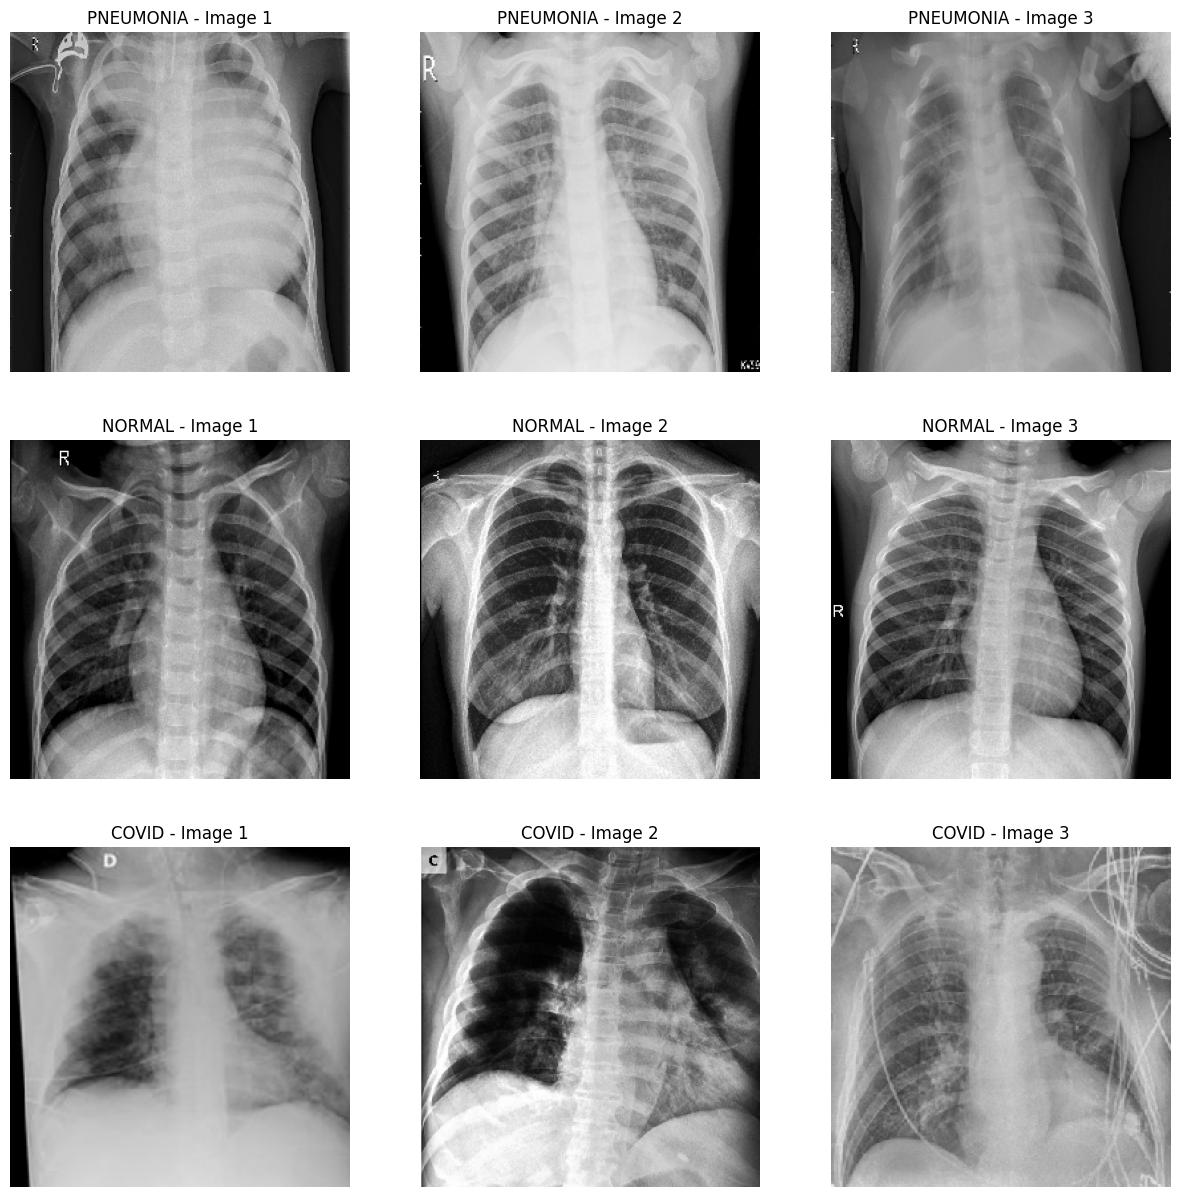

In [5]:
num_images = 3

fig, axes = plt.subplots(len(subfolders), num_images, figsize=(15, 5 * len(subfolders)))
for i, subfolder in enumerate(subfolders):
    images = [os.path.join(subfolder, img) for img in os.listdir(subfolder)[:num_images]]
    
    # Loop through each image in the subfolder
    for j, img_path in enumerate(images):
        img = plt.imread(img_path)  # Use matplotlib to read the image
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{os.path.basename(subfolder)} - Image {j + 1}")

In [13]:
image = plt.imread("/kaggle/input/covid-19pnuemonia/COVID/COVID_1002.png")

Image Shape: (232, 232, 3)
Image Data Type: float32
Min Pixel Value: 0.0
Max Pixel Value: 1.0


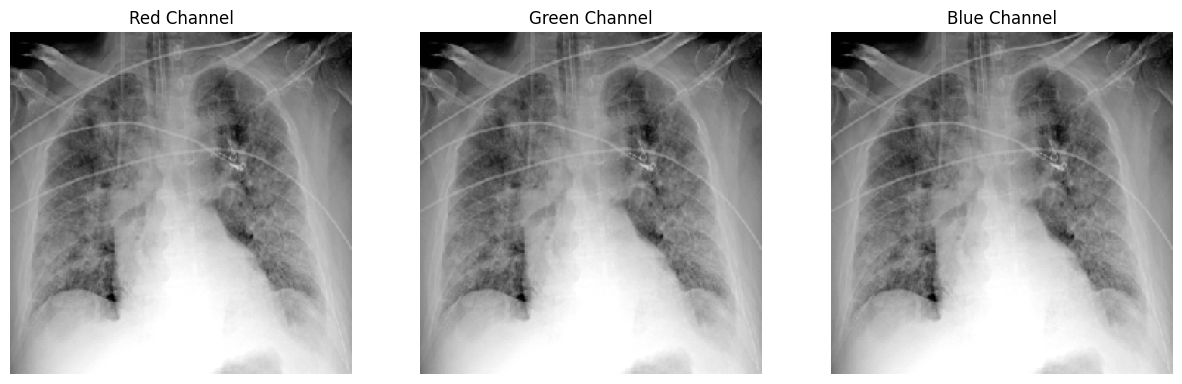

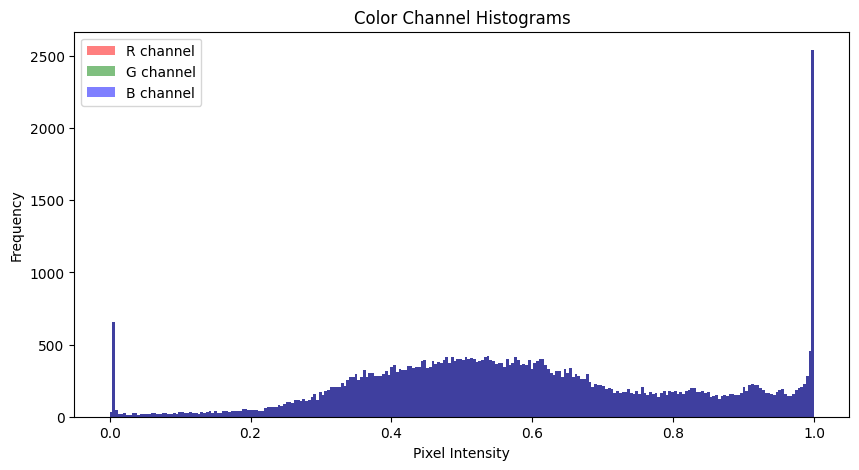

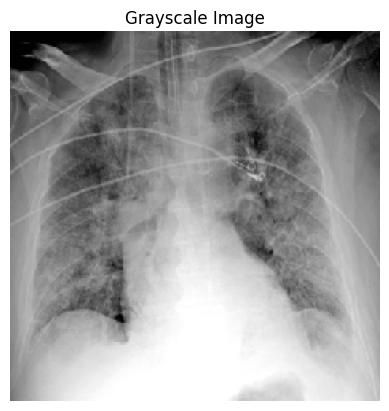

In [14]:
print("Image Shape:", image.shape)
print("Image Data Type:", image.dtype)
print("Min Pixel Value:", image.min())
print("Max Pixel Value:", image.max())

# Display individual color channels (if the image is RGB)
if len(image.shape) == 3 and image.shape[2] == 3:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    color_channels = ['Red', 'Green', 'Blue']
    
    for i, color in enumerate(color_channels):
        channel = image[:, :, i]
        axes[i].imshow(channel, cmap='gray')
        axes[i].set_title(f"{color} Channel")
        axes[i].axis('off')
    plt.show()

# Display histogram for each color channel
if len(image.shape) == 3 and image.shape[2] == 3:
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(10, 5))
    
    for i, color in enumerate(colors):
        plt.hist(image[:, :, i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.capitalize()} channel')
    
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Color Channel Histograms")
    plt.legend()
    plt.show()

# Convert the image to grayscale (if needed)
if len(image.shape) == 3:
    grayscale_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])  # Convert RGB to grayscale
    plt.imshow(grayscale_image, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

## Load data as numpy arrays

In [6]:
def load_data_as_numpy(main_folder_path):
    data = []
    labels = []
    class_names = sorted(os.listdir(main_folder_path))  # Ensure consistent order

    for label, subfolder in enumerate(class_names):
        subfolder_path = os.path.join(main_folder_path, subfolder)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            
            # Preprocess each image
            image = preprocess_image(image_path)
            data.append(image)
            labels.append(label)
    
    # Convert to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode
    
    return data, labels, class_names

# Paper 1: A Combined Approach Using Image Processing and Deep Learning to Detect Pneumonia from Chest X-Ray Image (https://ieeexplore.ieee.org/document/9303543)

### Preprocessing
- Contrast Limited Adaptive Histogram Equalization (CLAHE).
- Vertical cropping of the image.
- Finding and cropping around the largest contours representing lung regions.

In [16]:
def preprocess_image(image_path):
    # Step 1: Load image as grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Step 2: Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_clahe = clahe.apply(image)

    # Step 3: Vertical cropping (6% on both sides)
    height, width = image_clahe.shape
    cropped_image = image_clahe[:, int(0.06 * width):int(0.94 * width)]
    
    # Step 4: Find the largest two contours
    _, thresh = cv2.threshold(cropped_image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]  # Top 2 largest contours

    # Determine leftmost and rightmost points
    leftmost = min([pt[0][0] for contour in contours for pt in contour])
    rightmost = max([pt[0][0] for contour in contours for pt in contour])

    # Crop image based on contours
    final_image = cropped_image[:, leftmost:rightmost]

    # Resize to 128x128
    final_image = cv2.resize(final_image, (128, 128))
    
    return final_image

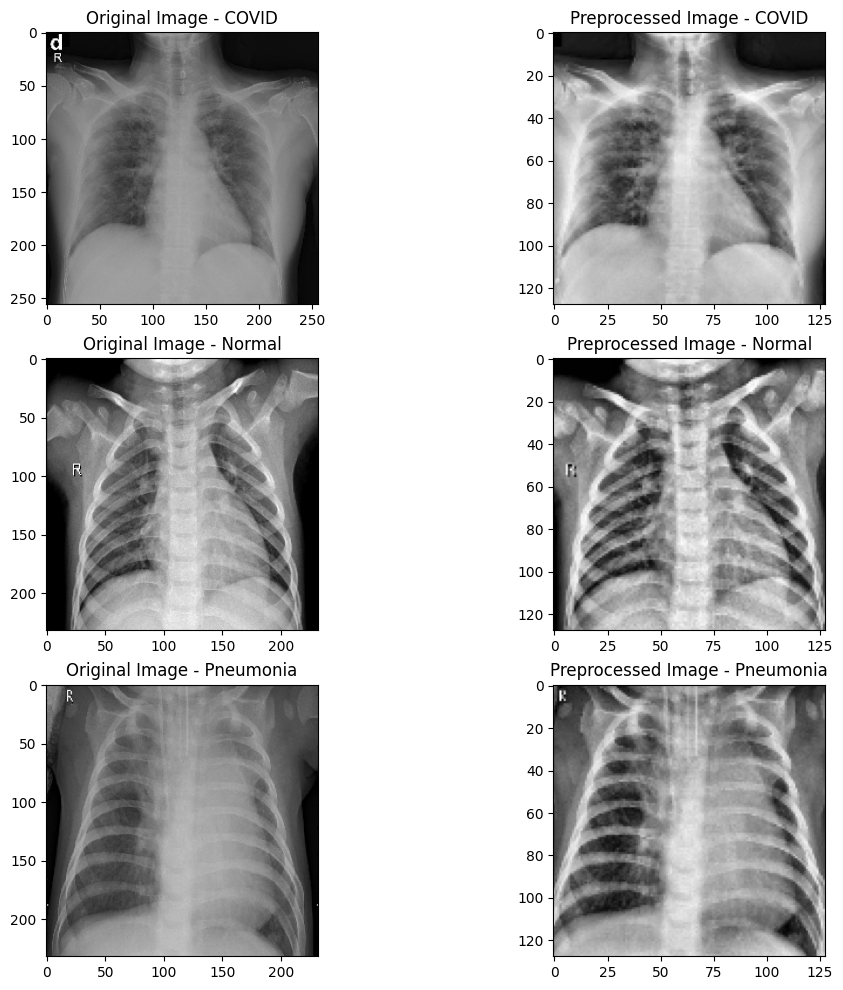

In [17]:
# Test preprocessing on a sample image
image_path1 = "/kaggle/input/covid-19pnuemonia/COVID/COVID_101.png"
processed_image1 = preprocess_image(image_path1)
image_path2 = "/kaggle/input/covid-19pnuemonia/NORMAL/NORMAL_101.png"
processed_image2 = preprocess_image(image_path2)
image_path3 = "/kaggle/input/covid-19pnuemonia/PNEUMONIA/PNEUMONIA_101.png"
processed_image3 = preprocess_image(image_path3)
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(cv2.imread(image_path1), cmap='gray')
plt.title("Original Image - COVID")
plt.subplot(3,2,2)
plt.imshow(processed_image1, cmap='gray')
plt.title("Preprocessed Image - COVID")
plt.subplot(3,2,3)
plt.imshow(cv2.imread(image_path2), cmap='gray')
plt.title("Original Image - Normal")
plt.subplot(3,2,4)
plt.imshow(processed_image2, cmap='gray')
plt.title("Preprocessed Image - Normal")
plt.subplot(3,2,5)
plt.imshow(cv2.imread(image_path3), cmap='gray')
plt.title("Original Image - Pneumonia")
plt.subplot(3,2,6)
plt.imshow(processed_image3, cmap='gray')
plt.title("Preprocessed Image - Pneumonia")
plt.show()

In [18]:
data, labels, class_names = load_data_as_numpy(folder_path)

In [19]:
# Split data into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, stratify=train_labels)

### Model defining and compiling

In [3]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to binary labels
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.argmax(y_true, axis=1)

        # Calculate true positives, false positives, and false negatives
        tp = tf.reduce_sum(tf.cast(y_true * y_pred, "float32"))
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float32"))
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float32"))

        # Update the state variables
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        # Calculate precision, recall, and F1-score
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1_score

    def reset_states(self):
        # Reset state variables for new metric calculation
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [4]:
def create_vgg_19_model(model_type='VGG19', input_shape=(128, 128, 1), num_classes=3):
    if model_type == 'VGG19':
        base_model = VGG19(weights=None, include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output nodes equal to number of classes

    model1_1 = Model(inputs=base_model.input, outputs=x)
    model1_1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    
    return model1_1

In [5]:
def create_vgg_16_model(model_type='VGG16', input_shape=(128, 128, 1), num_classes=3):
    if model_type == 'VGG16':
        base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output nodes equal to number of classes

    model1_2 = Model(inputs=base_model.input, outputs=x)
    model1_2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    
    return model1_2

In [23]:
def create_vgg16_model(model_type='VGG16', input_shape=(128, 128, 1), num_classes=3):
    if model_type == 'VGG16':
        base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output nodes equal to number of classes

    model1_3 = Model(inputs=base_model.input, outputs=x)
    model1_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    
    return model1_3

In [6]:
model1_1 = create_vgg_19_model()
model1_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,53

 Total params: 24,219,587 (92.39 MB)

 Trainable params: 24,219,587 (92.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model1_2 = create_vgg_16_model()
model1_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,909,891 (72.14 MB)

 Trainable params: 18,909,891 (72.14 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Create the model
model1_1 = create_vgg_19_model()
checkpoint = ModelCheckpoint('vgg_19.keras', monitor='val_loss', save_best_only=True, mode='min')

In [25]:
# Create the model
model1_2 = create_vgg_16_model()
checkpoint = ModelCheckpoint('vgg_16.keras', monitor='val_loss', save_best_only=True, mode='min')

In [26]:
# Create the model
model1_3 = create_vgg16_model()
checkpoint = ModelCheckpoint('vgg16.keras', monitor='val_loss', save_best_only=True, mode='min')

## Training

In [27]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model1_1.fit(
    train_data, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[checkpoint]
)

Epoch 1/50


I0000 00:00:1733644796.942599     108 service.cc:145] XLA service 0x796b0c002290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733644796.942656     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733644796.942661     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/105 ━━━━━━━━━━━━━━━━━━━━ 44:29 26s/step - accuracy: 0.3125 - f1_score: 0.0000e+00 - loss: 1.1244

I0000 00:00:1733644818.616400     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 332ms/step - accuracy: 0.4234 - f1_score: 1.2376 - loss: 1.0628 - val_accuracy: 0.7873 - val_f1_score: 1.3501 - val_loss: 0.5040
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.8544 - f1_score: 1.5564 - loss: 0.3929 - val_accuracy: 0.9068 - val_f1_score: 1.6315 - val_loss: 0.2591
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9322 - f1_score: 1.6087 - loss: 0.2163 - val_accuracy: 0.9223 - val_f1_score: 1.6427 - val_loss: 0.2397
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.9454 - f1_score: 1.6133 - loss: 0.1739 - val_accuracy: 0.9283 - val_f1_score: 1.5826 - val_loss: 0.1972
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - accuracy: 0.9485 - f1_score: 1.6380 - loss: 0.1486 - val_accuracy: 0.9486 - val_f1_score: 1.6144 - val_loss: 0.1500
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.9587 - f1_score: 1.6344 - loss: 0.1271 - val_accuracy: 0.9558 - val_f1_score:

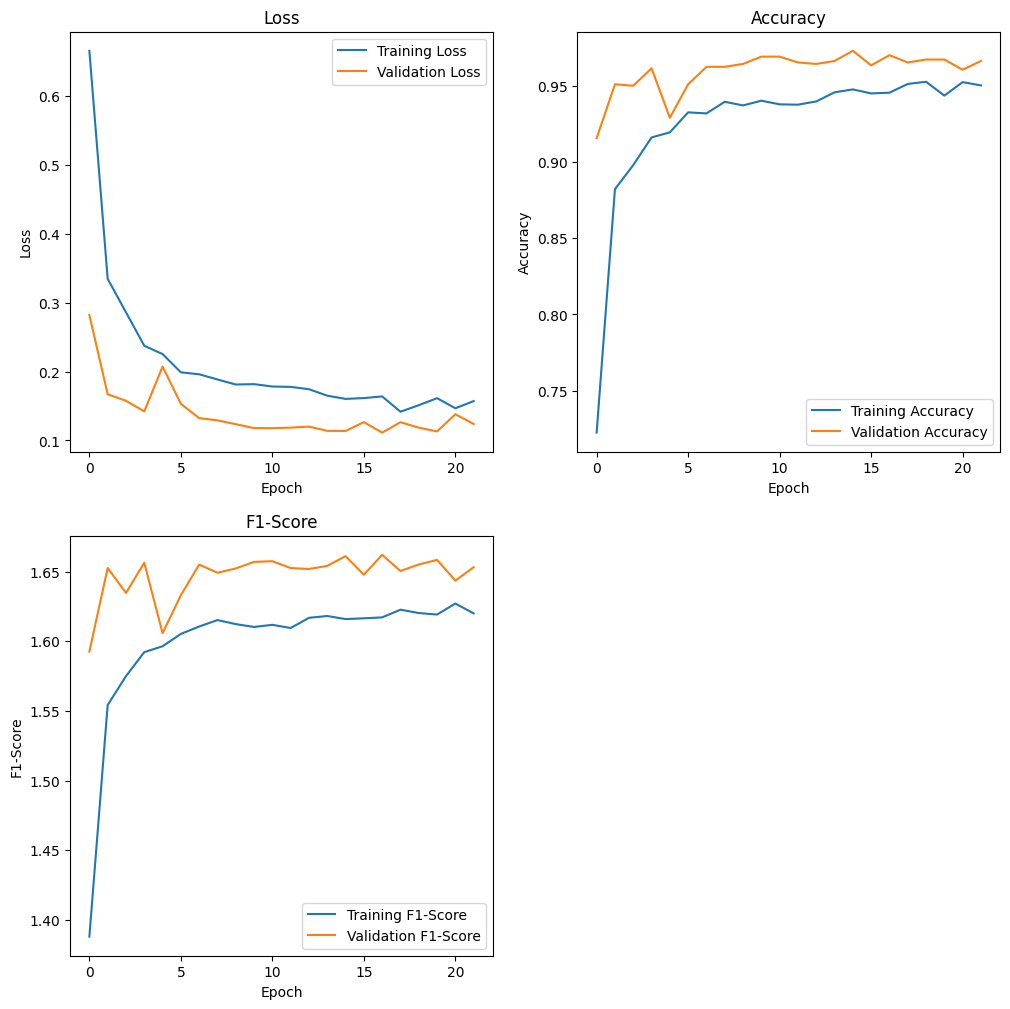

In [85]:
# Plot loss, accuracy, and F1-score
plt.figure(figsize=(12, 12))

# Loss plot
plt.subplot(2,2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2,2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1-score plot
plt.subplot(2,2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.show()

In [29]:
model1_1.save("vgg_19.keras")

In [30]:
# Step 4: Load the saved model and evaluate on test data
saved_model = tf.keras.models.load_model("vgg_19.keras", custom_objects={'F1Score': F1Score})
test_predictions = saved_model.predict(test_data)
y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       325
      NORMAL       0.96      0.98      0.97       361
   PNEUMONIA       0.98      0.96      0.97       360

    accuracy                           0.97      1046
   macro avg       0.97      0.97      0.97      1046
weighted avg       0.97      0.97      0.97      1046

Confusion Matrix:
 [[320   4   1]
 [  2 352   7]
 [  3  11 346]]


In [31]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model1_2.fit(
    train_data, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[checkpoint]
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 196ms/step - accuracy: 0.5314 - f1_score: 1.3143 - loss: 0.9202 - val_accuracy: 0.7216 - val_f1_score: 1.6644 - val_loss: 0.4996
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.8962 - f1_score: 1.5873 - loss: 0.2844 - val_accuracy: 0.9247 - val_f1_score: 1.5950 - val_loss: 0.2369
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.9404 - f1_score: 1.6196 - loss: 0.1766 - val_accuracy: 0.9462 - val_f1_score: 1.6092 - val_loss: 0.1439
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.9425 - f1_score: 1.6091 - loss: 0.1417 - val_accuracy: 0.9474 - val_f1_score: 1.6244 - val_loss: 0.1549
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.9500 - f1_score: 1.6387 - loss: 0.1365 - val_accuracy: 0.9427 - val_f1_score: 1.6053 - val_loss: 0.1555
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.9652 - f1_score: 1.6352 - loss: 0.1088 - val_accuracy: 0.9665 - va

## Plotting

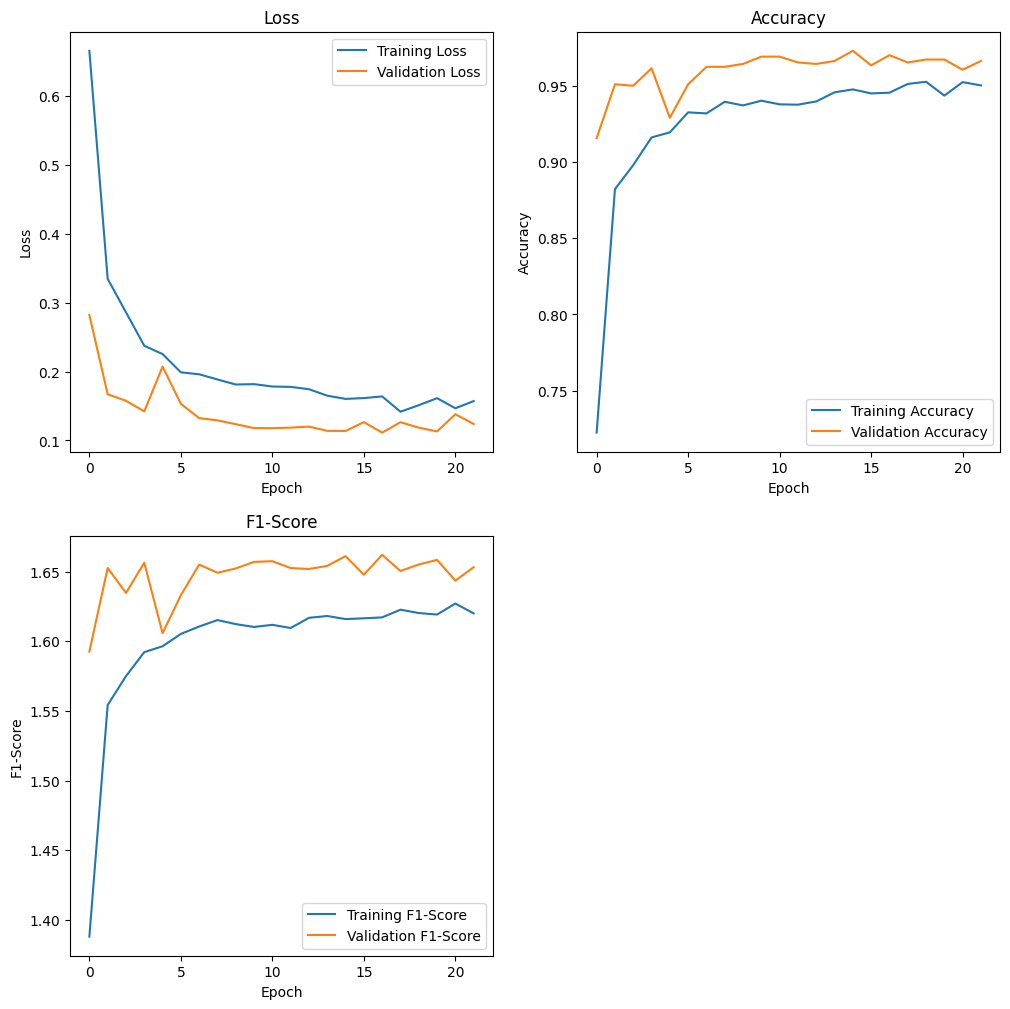

In [84]:
# Plot loss, accuracy, and F1-score
plt.figure(figsize=(12,12))

# Loss plot
plt.subplot(2,2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2,2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1-score plot
plt.subplot(2,2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.show()

In [33]:
model1_2.save("vgg_16.keras")

In [34]:
# Step 4: Load the saved model and evaluate on test data
saved_model = tf.keras.models.load_model("vgg_16.keras", custom_objects={'F1Score': F1Score})
test_predictions = saved_model.predict(test_data)
y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.97      0.99      0.98       325
      NORMAL       0.95      0.97      0.96       361
   PNEUMONIA       0.98      0.94      0.96       360

    accuracy                           0.97      1046
   macro avg       0.97      0.97      0.97      1046
weighted avg       0.97      0.97      0.97      1046

Confusion Matrix:
 [[321   3   1]
 [  4 351   6]
 [  6  14 340]]


In [35]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model1_3.fit(
    train_data, train_labels,
    epochs=50,
    batch_size=32,
    validation_data=(val_data, val_labels),
    callbacks=[checkpoint]
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.3379 - f1_score: 1.2378 - loss: 57.9987 - val_accuracy: 0.3441 - val_f1_score: 1.3627 - val_loss: 1.0978
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - accuracy: 0.3349 - f1_score: 1.0336 - loss: 1.0990 - val_accuracy: 0.3453 - val_f1_score: 1.0165 - val_loss: 1.0974
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 0.3476 - f1_score: 1.2165 - loss: 1.1139 - val_accuracy: 0.3441 - val_f1_score: 1.3627 - val_loss: 1.0975
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.3312 - f1_score: 1.0986 - loss: 1.0981 - val_accuracy: 0.3441 - val_f1_score: 1.3627 - val_loss: 1.0974
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.3418 - f1_score: 1.3129 - loss: 1.1024 - val_accuracy: 0.3441 - val_f1_score: 1.3627 - val_loss: 1.0977
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.3407 - f1_score: 1.3385 - loss: 1.0997 - val_accuracy: 0.3453 - v

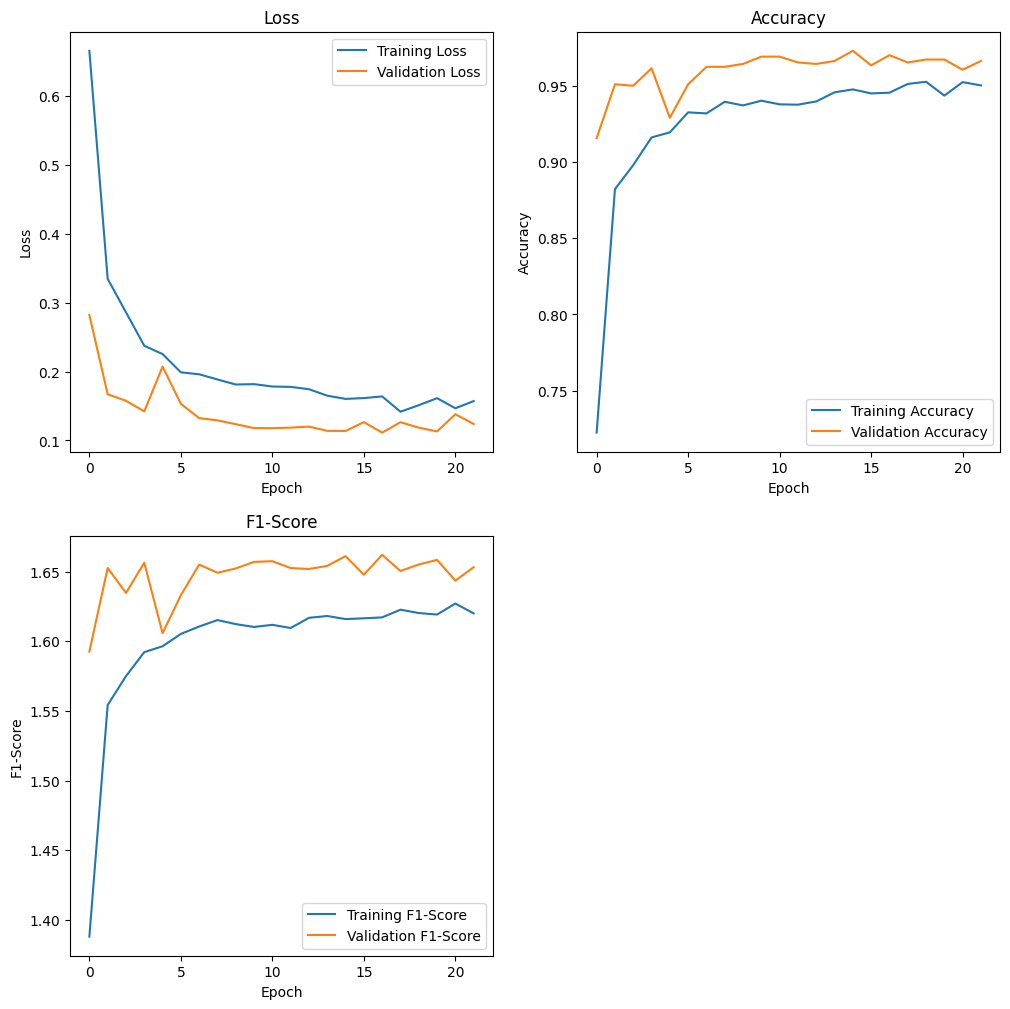

In [82]:
# Plot loss, accuracy, and F1-score
plt.figure(figsize=(12, 12))

# Loss plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(2,2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1-score plot
plt.subplot(2,2 , 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.show()

In [37]:
model1_3.save("vgg16.keras")

In [38]:
# Step 4: Load the saved model and evaluate on test data
saved_model = tf.keras.models.load_model("vgg16.keras", custom_objects={'F1Score': F1Score})
test_predictions = saved_model.predict(test_data)
y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.00      0.00      0.00       325
      NORMAL       0.00      0.00      0.00       361
   PNEUMONIA       0.34      1.00      0.51       360

    accuracy                           0.34      1046
   macro avg       0.11      0.33      0.17      1046
weighted avg       0.12      0.34      0.18      1046

Confusion Matrix:
 [[  0   0 325]
 [  0   0 361]
 [  0   0 360]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Paper 2: Multiple Lung Diseases Classification from Chest X- Ray Images Using Deep Learning Approach

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image_path):
    # Load image as grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply preprocessing steps (median filter and CLAHE)
    image = cv2.medianBlur(image, 3)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    
    # Resize and convert to RGB by stacking channels
    image = cv2.resize(image, (299, 299))
    image_rgb = np.stack((image,)*3, axis=-1)  # Stack to create 3 channels
    
    return image_rgb


# Load and preprocess images into arrays (Example with three classes)
def load_data(main_folder_path):
    data = []
    labels = []
    class_names = sorted(os.listdir(main_folder_path))  # Ensure consistent order
    
    for label, subfolder in enumerate(class_names):
        subfolder_path = os.path.join(main_folder_path, subfolder)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (299, 299))
            data.append(image)
            labels.append(label)
            
    data = np.array(data)  # No need to add a channel dimension since it's already RGB
    labels = np.array(labels)
    #labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encode

    # Print shapes for verification
    print("Loaded images shape:", data.shape)
    print("Loaded labels shape:", labels.shape)
    
    return data, labels, class_names

In [8]:
data, labels, class_names = load_data(folder_path)
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, stratify=labels)

# Confirm shapes
print(f"Images shape: {train_images.shape}")  # Should be (num_samples, 299, 299, 3)
print(f"Labels shape: {train_labels.shape}")   # Should be (num_samples,)

from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, num_classes=len((class_names)))

Loaded images shape: (5228, 299, 299, 3)
Loaded labels shape: (5228,)
Images shape: (4182, 299, 299, 3)
Labels shape: (4182,)


In [18]:
print("Shape of test_labels:", test_labels.shape)

Shape of test_labels: (1046,)


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80-20 split for training and validation
)

train_generator = train_datagen.flow(
    train_images, train_labels,
    batch_size=32,
    subset='training'
)

validation_generator = train_datagen.flow(
    train_images, train_labels,
    batch_size=32,
    subset='validation'
)

## Model

In [4]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Xception base model with ImageNet weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Multi-class output layer

# Compile the model
model2 = Model(inputs=base_model.input, outputs=x)

model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_12[0][0]    

 Total params: 21,912,107 (83.59 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [12]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Xception base model with ImageNet weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(class_names), activation='softmax')(x)  # Multi-class output layer

# Compile the model
model2 = Model(inputs=base_model.input, outputs=x)
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])

# Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('paper2.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [13]:
history = model2.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733756805.872161      93 service.cc:145] XLA service 0x78b740002950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733756805.872224      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733756805.872228      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-09 15:06:52.808486: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,1,3,3]{3,

105/105 ━━━━━━━━━━━━━━━━━━━━ 127s 924ms/step - accuracy: 0.8428 - f1_score: 1.5239 - loss: 0.4030 - val_accuracy: 0.9438 - val_f1_score: 1.6336 - val_loss: 0.1561
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 77s 697ms/step - accuracy: 0.9211 - f1_score: 1.6027 - loss: 0.2113 - val_accuracy: 0.9557 - val_f1_score: 1.6438 - val_loss: 0.1465
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 684ms/step - accuracy: 0.9395 - f1_score: 1.5903 - loss: 0.1699 - val_accuracy: 0.9402 - val_f1_score: 1.6517 - val_loss: 0.1954
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 688ms/step - accuracy: 0.9272 - f1_score: 1.6094 - loss: 0.2005 - val_accuracy: 0.9474 - val_f1_score: 1.6249 - val_loss: 0.1653
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 77s 689ms/step - accuracy: 0.9359 - f1_score: 1.6105 - loss: 0.1694 - val_accuracy: 0.9402 - val_f1_score: 1.6441 - val_loss: 0.1667
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 78s 705ms/step - accuracy: 0.9412 - f1_score: 1.6211 - loss: 0.1632 - val_accuracy: 0.9605 - val_f1_score

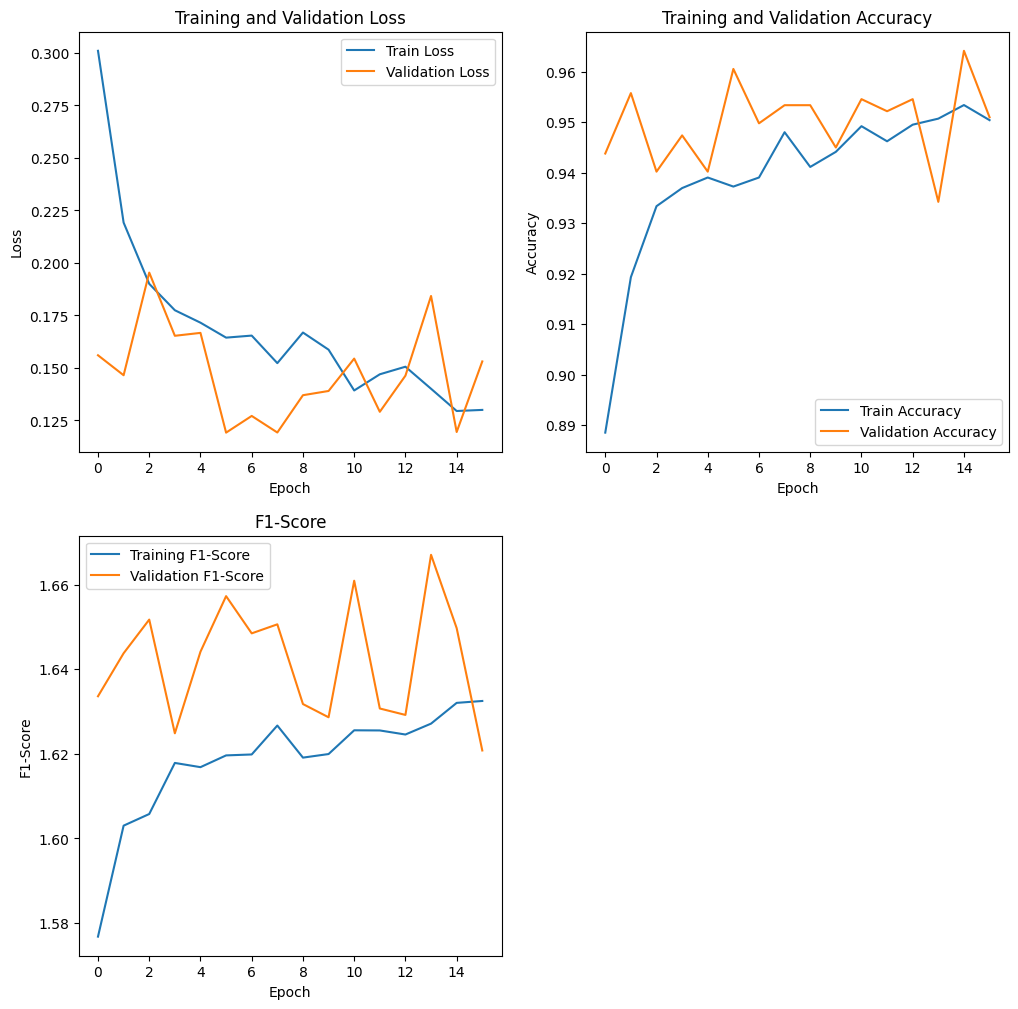

In [14]:
plt.figure(figsize=(12, 12))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


# F1-score plot
plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.show()

In [20]:
# Step 4: Load the saved model and evaluate on test data
saved_model = tf.keras.models.load_model("paper2.keras", custom_objects={'F1Score': F1Score})
test_predictions = saved_model.predict(test_images)
y_pred = np.argmax(test_predictions, axis=1)
y_true = test_labels

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 296ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.00      0.00      0.00       325
      NORMAL       0.37      1.00      0.54       361
   PNEUMONIA       0.12      0.02      0.03       360

    accuracy                           0.35      1046
   macro avg       0.16      0.34      0.19      1046
weighted avg       0.17      0.35      0.20      1046

Confusion Matrix:
 [[  0 274  51]
 [  0 361   0]
 [  0 353   7]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Paper 3: 2024 - Detection of Covid-19 Cases from Chest X-Ray Images using CNN

In [31]:
data, labels, class_names = load_data_as_numpy(folder_path)
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

## Model

In [40]:
def cnn_model(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')  # Output layer with number of classes
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    return model

In [41]:
# Instantiate and summarize the model
model3 = cnn_model(input_shape=(data.shape[1], data.shape[2], data.shape[3]))  # Adapt to your data shape
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 297, 297, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,164,163 (76.92 MB)

 Trainable params: 20,164,163 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('paper3.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model3.fit(
    train_images, train_labels,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.5846 - f1_score: 1.2606 - loss: 99.6578 - val_accuracy: 0.9271 - val_f1_score: 1.5932 - val_loss: 0.2824
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9158 - f1_score: 1.5903 - loss: 0.2552 - val_accuracy: 0.9355 - val_f1_score: 1.6018 - val_loss: 0.1702
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9431 - f1_score: 1.6149 - loss: 0.1644 - val_accuracy: 0.9498 - val_f1_score: 1.5904 - val_loss: 0.1458
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9463 - f1_score: 1.6372 - loss: 0.1849 - val_accuracy: 0.9427 - val_f1_score: 1.5978 - val_loss: 0.1493
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.9611 - f1_score: 1.6246 - loss: 0.1127 - val_accuracy: 0.8961 - val_f1_score: 1.5143 - val_loss: 0.4275
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.9571 - f1_score: 1.6192 - loss: 0.1154 - val_accuracy: 0.9582 - val_f1_sc

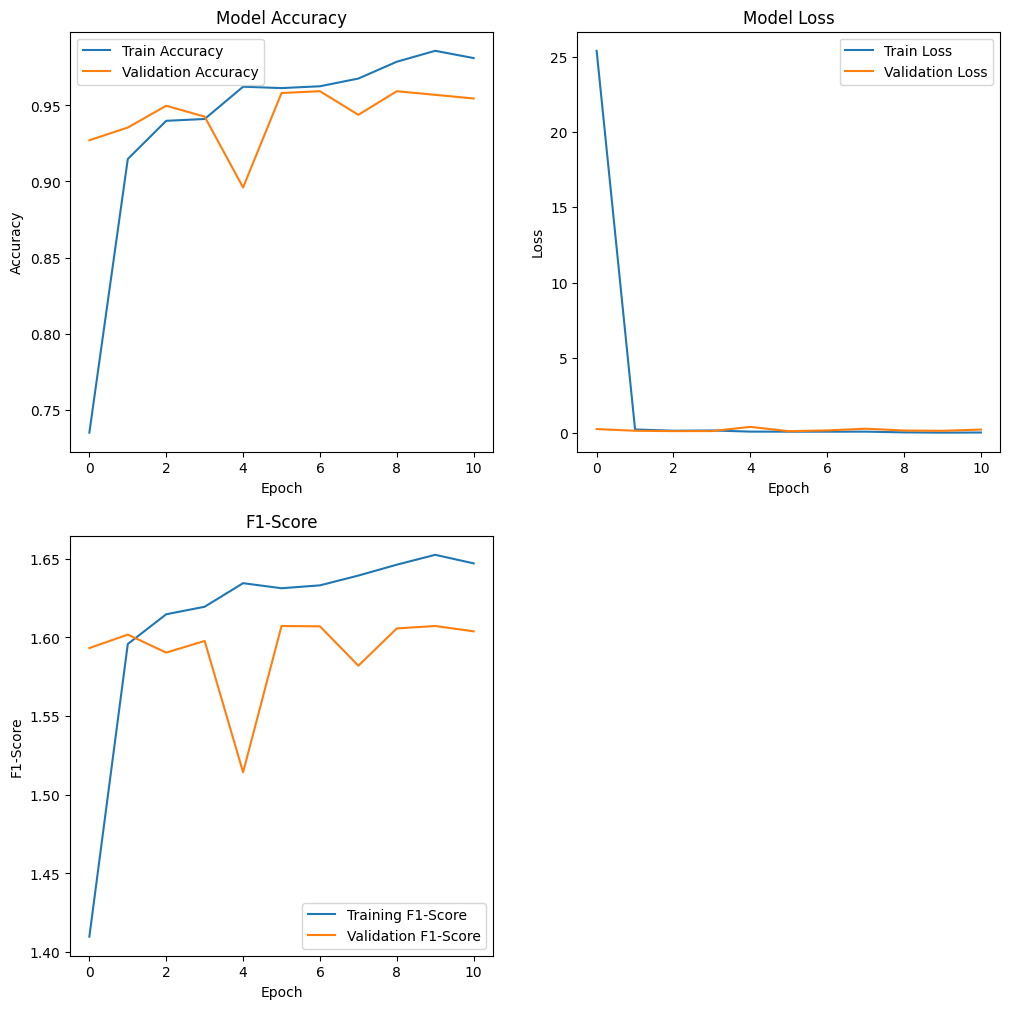

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()


plt.show()


In [46]:
# Step 4: Load the saved model and evaluate on test data
saved_model = tf.keras.models.load_model("paper3.keras", custom_objects={'F1Score': F1Score})
test_predictions = saved_model.predict(test_images)
y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.97      0.95      0.96       351
      NORMAL       0.95      0.95      0.95       330
   PNEUMONIA       0.93      0.95      0.94       365

    accuracy                           0.95      1046
   macro avg       0.95      0.95      0.95      1046
weighted avg       0.95      0.95      0.95      1046

Confusion Matrix:
 [[332   6  13]
 [  4 312  14]
 [  7  10 348]]


# Paper 4 : 2024 - Unleashing the power of advanced technologies for revolutionary medical imaging pioneering the healthcare frontier with artificial intelligence

## Data Loading

In [50]:
def load_data_as_numpy(main_folder_path):
    data = []
    labels = []
    class_names = sorted(os.listdir(main_folder_path))

    for label, subfolder in enumerate(class_names):
        subfolder_path = os.path.join(main_folder_path, subfolder)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            data.append(image / 255.0)  # Normalize
            labels.append(label)
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(class_names))
    
    return data, labels, class_names

# Load the data
main_folder_path = '/kaggle/input/covid-19pnuemonia'
data, labels, class_names = load_data_as_numpy(main_folder_path)

# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

## Model


In [51]:
def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Define the input tensor
    inputs = Input(shape=input_shape)
    
    # Load ResNet50 as the base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False  # Freeze the base model layers

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the complete model
    model4 = Model(inputs=inputs, outputs=outputs)
    model4.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    return model4

In [52]:
model4 = create_model()
model4.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Training

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet50_model.keras', monitor='val_loss', save_best_only=True)

history = model4.fit(
    train_images, train_labels,
    epochs=75,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.3744 - f1_score: 1.1372 - loss: 1.2915 - val_accuracy: 0.3680 - val_f1_score: 1.4005 - val_loss: 1.0758
Epoch 2/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.3912 - f1_score: 1.1609 - loss: 1.1070 - val_accuracy: 0.7575 - val_f1_score: 1.3682 - val_loss: 1.0151
Epoch 3/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.4636 - f1_score: 1.1212 - loss: 1.0365 - val_accuracy: 0.5568 - val_f1_score: 1.3897 - val_loss: 0.9849
Epoch 4/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.5262 - f1_score: 1.1732 - loss: 0.9929 - val_accuracy: 0.7503 - val_f1_score: 1.3667 - val_loss: 0.9462
Epoch 5/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.5914 - f1_score: 1.1463 - loss: 0.9593 - val_accuracy: 0.6894 - val_f1_score: 1.4599 - val_loss: 0.9227
Epoch 6/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.6313 - f1_score: 1.2551 - loss: 0.9271 - val_accuracy: 0.6416 - va

## Plot and validate

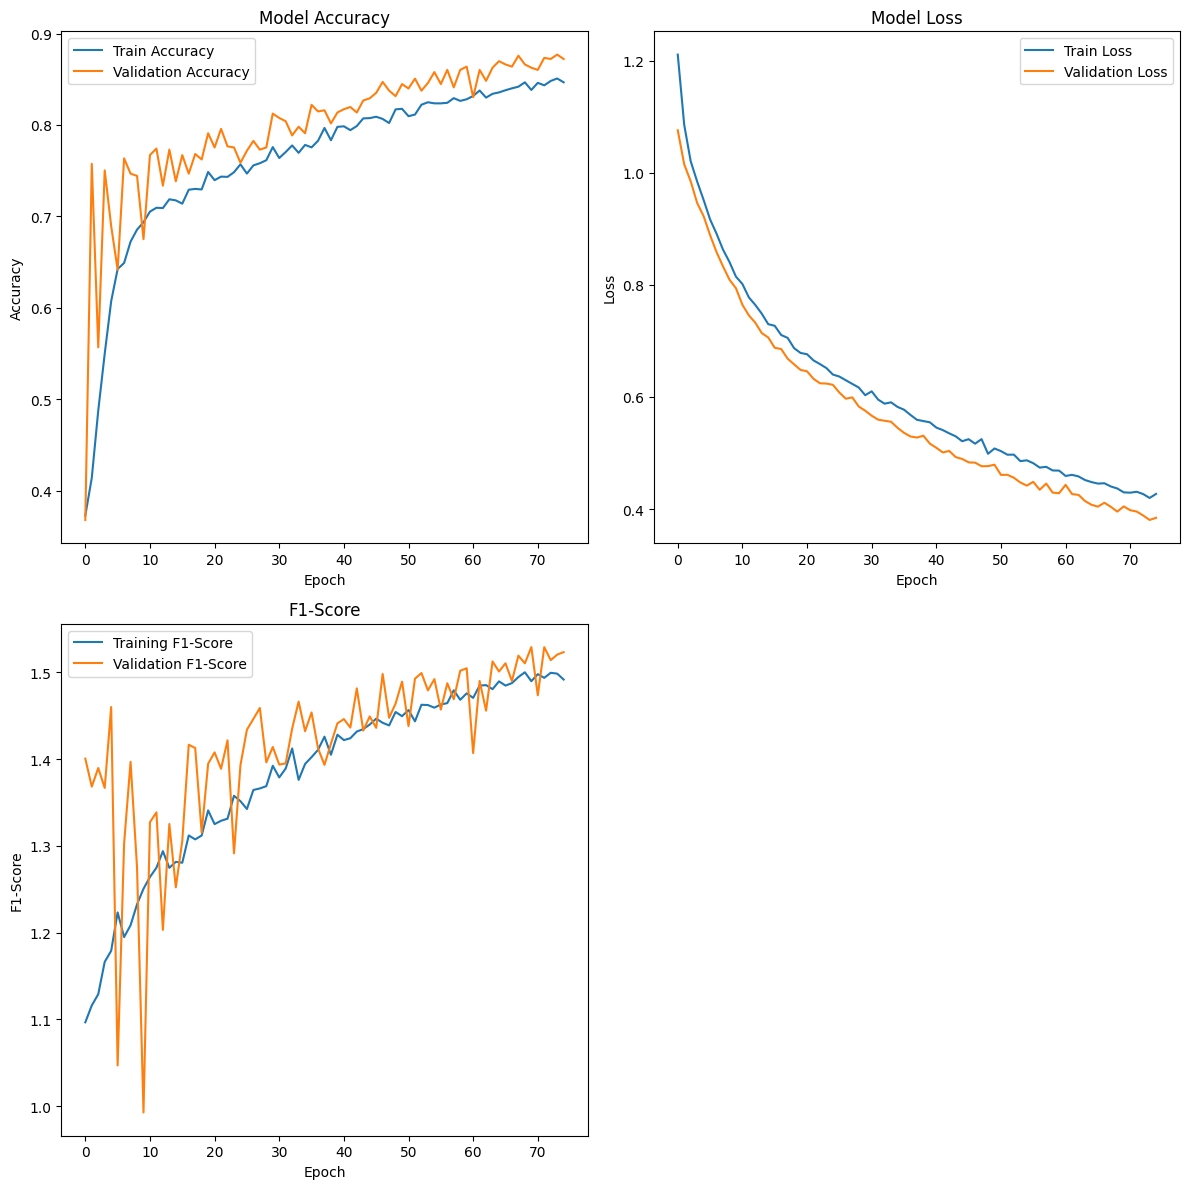

In [54]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()

plt.tight_layout()
plt.show()



## Evaluate

In [59]:
# Load the best model
best_model = tf.keras.models.load_model('best_resnet50_model.keras',  custom_objects={'F1Score': F1Score})

# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)[:2]
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions and classification report
y_pred = np.argmax(best_model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.8752 - f1_score: 1.5550 - loss: 0.3585
Test Accuracy: 87.76%
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.91      0.96      0.93       351
      NORMAL       0.84      0.89      0.86       330
   PNEUMONIA       0.88      0.79      0.84       365

    accuracy                           0.88      1046
   macro avg       0.88      0.88      0.88      1046
weighted avg       0.88      0.88      0.88      1046

Confusion Matrix:
 [[336   5  10]
 [  9 293  28]
 [ 24  52 289]]


# Paper 5: 2024 - X-Ray Image Classification with Neural Networks

## Data prep

In [60]:
def load_data_as_numpy(main_folder_path, img_size=(128, 128)):
    data = []
    labels = []
    class_names = sorted(os.listdir(main_folder_path))  # Ensure consistent order
    
    for label, subfolder in enumerate(class_names):
        subfolder_path = os.path.join(main_folder_path, subfolder)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, img_size)  # Resize to specified size
            data.append(image / 255.0)  # Normalize pixel values
            labels.append(label)
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(class_names))  # One-hot encoding
    return data, labels, class_names

# Load and split data
main_folder_path = '/kaggle/input/covid-19pnuemonia'
data, labels, class_names = load_data_as_numpy(main_folder_path, img_size=(128, 128))

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

## Data Augmentation

In [61]:
# Augment the training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Use the generator
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

## Model

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_cnn_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    return model

In [67]:
# Instantiate the model
model5 = create_cnn_model()
model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,795,651 (25.92 MB)

 Trainable params: 6,794,755 (25.92 MB)

 Non-trainable params: 896 (3.50 KB)

## Training

In [68]:
# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_paper5_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model5.fit(
    train_generator,
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.5928 - f1_score: 1.3313 - loss: 1.4293 - val_accuracy: 0.3356 - val_f1_score: 0.0000e+00 - val_loss: 11.3518
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.7234 - f1_score: 1.4438 - loss: 0.6394 - val_accuracy: 0.3356 - val_f1_score: 0.0000e+00 - val_loss: 15.4075
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - accuracy: 0.7773 - f1_score: 1.4782 - loss: 0.5453 - val_accuracy: 0.5076 - val_f1_score: 1.1637 - val_loss: 13.2527
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.7845 - f1_score: 1.4570 - loss: 0.5285 - val_accuracy: 0.6185 - val_f1_score: 1.5825 - val_loss: 7.0308
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.8147 - f1_score: 1.4868 - loss: 0.4929 - val_accuracy: 0.7199 - val_f1_score: 1.6671 - val_loss: 1.5104
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - accuracy: 0.8221 - f1_score: 1.4984 - loss: 0.4680 - val_accuracy: 0.9216 - va

## Evaluate

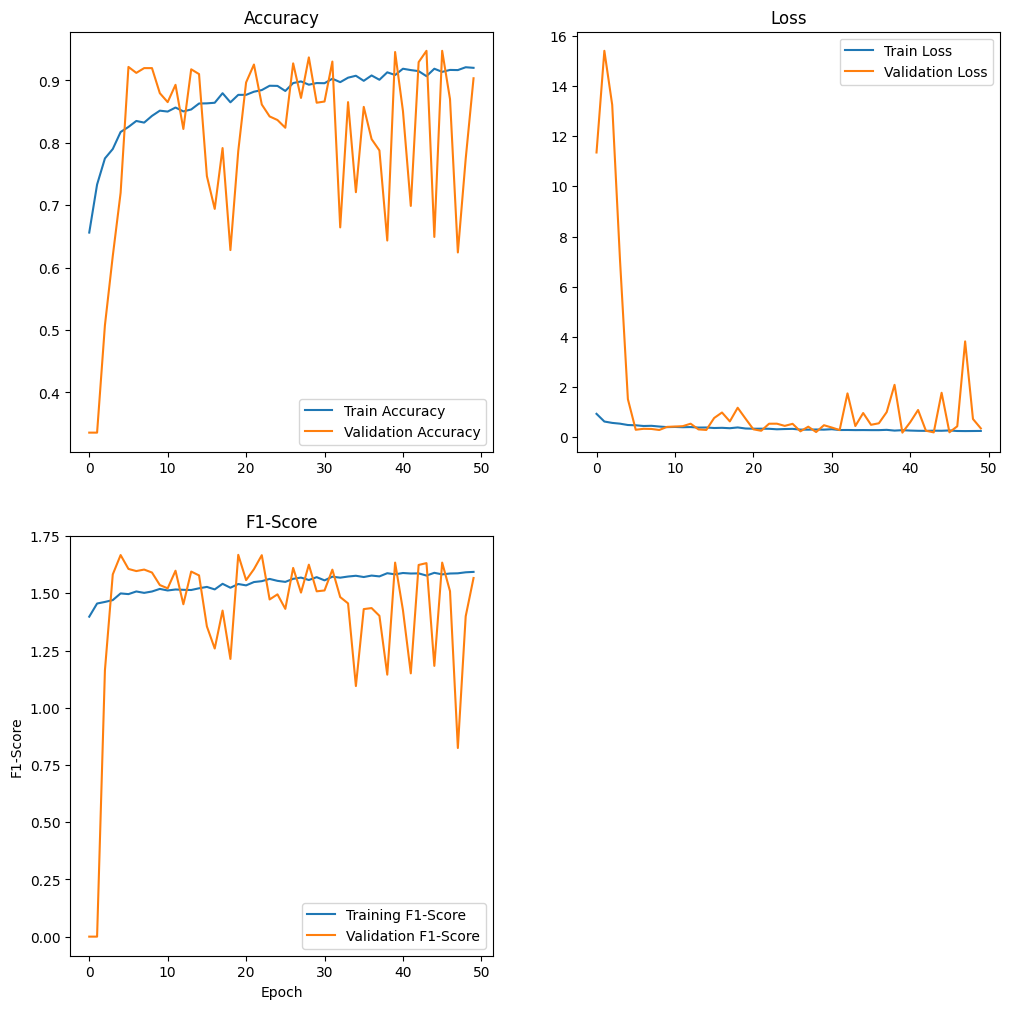

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9463 - f1_score: 1.6344 - loss: 0.1494
Test Accuracy: 94.55%
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.99      0.98      0.98       351
      NORMAL       0.89      0.97      0.93       330
   PNEUMONIA       0.96      0.90      0.93       365

    accuracy                           0.95      1046
   macro avg       0.95      0.95      0.95      1046
weighted avg       0.95      0.95      0.95      1046

Confusion Matrix:
 [[343   2   6]
 [  3 319   8]
 [  2  36 327]]


In [71]:
# Plot training and validation performance
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()


plt.show()

# Load the best model and evaluate
best_model = tf.keras.models.load_model('best_paper5_model.keras', custom_objects={'F1Score': F1Score})
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)[:2]
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions and evaluate
y_pred = np.argmax(best_model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Paper 6 : 2022 - A deep learning architecture for multi-class lung diseases classification using chest X-ray (CXR) images

## Data Prep

In [72]:
def load_data_as_numpy(main_folder_path, img_size=(224, 224)):
    data = []
    labels = []
    class_names = sorted(os.listdir(main_folder_path))
    
    for label, subfolder in enumerate(class_names):
        subfolder_path = os.path.join(main_folder_path, subfolder)
        for image_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, img_size)
            data.append(image / 255.0)  # Normalize pixel values
            labels.append(label)
    
    data = np.array(data, dtype="float32")
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(class_names))
    return data, labels, class_names

# Load and preprocess the data
main_folder_path = '/kaggle/input/covid-19pnuemonia'
data, labels, class_names = load_data_as_numpy(main_folder_path, img_size=(224, 224))

# Split data
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)  

## Model

In [73]:
def create_vgg19_cnn_model(input_shape=(224, 224, 3), num_classes=len(class_names)):
    # Load the VGG19 model
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze VGG19 layers

    # Add custom CNN layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', F1Score()])
    return model

In [74]:
model6 = create_vgg19_cnn_model()
model6.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             

 Total params: 33,002,051 (125.89 MB)

 Trainable params: 12,977,667 (49.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

## Data Augementation and training

In [75]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Create augmented data generator
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_paper6_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model6.fit(
    train_generator,
    validation_data=(test_images, test_labels),
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 440ms/step - accuracy: 0.5928 - f1_score: 1.2663 - loss: 0.9586 - val_accuracy: 0.9159 - val_f1_score: 1.5926 - val_loss: 0.2822
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 324ms/step - accuracy: 0.8688 - f1_score: 1.5263 - loss: 0.3641 - val_accuracy: 0.9512 - val_f1_score: 1.6526 - val_loss: 0.1671
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 323ms/step - accuracy: 0.8920 - f1_score: 1.5590 - loss: 0.2978 - val_accuracy: 0.9503 - val_f1_score: 1.6347 - val_loss: 0.1576
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 321ms/step - accuracy: 0.9131 - f1_score: 1.6029 - loss: 0.2452 - val_accuracy: 0.9618 - val_f1_score: 1.6564 - val_loss: 0.1422
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 316ms/step - accuracy: 0.9189 - f1_score: 1.5855 - loss: 0.2300 - val_accuracy: 0.9293 - val_f1_score: 1.6058 - val_loss: 0.2073
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 314ms/step - accuracy: 0.9326 - f1_score: 1.6020 - loss: 0.1929 - val_accuracy: 0.9512 - val_f1_score:

## Validation and evaluation

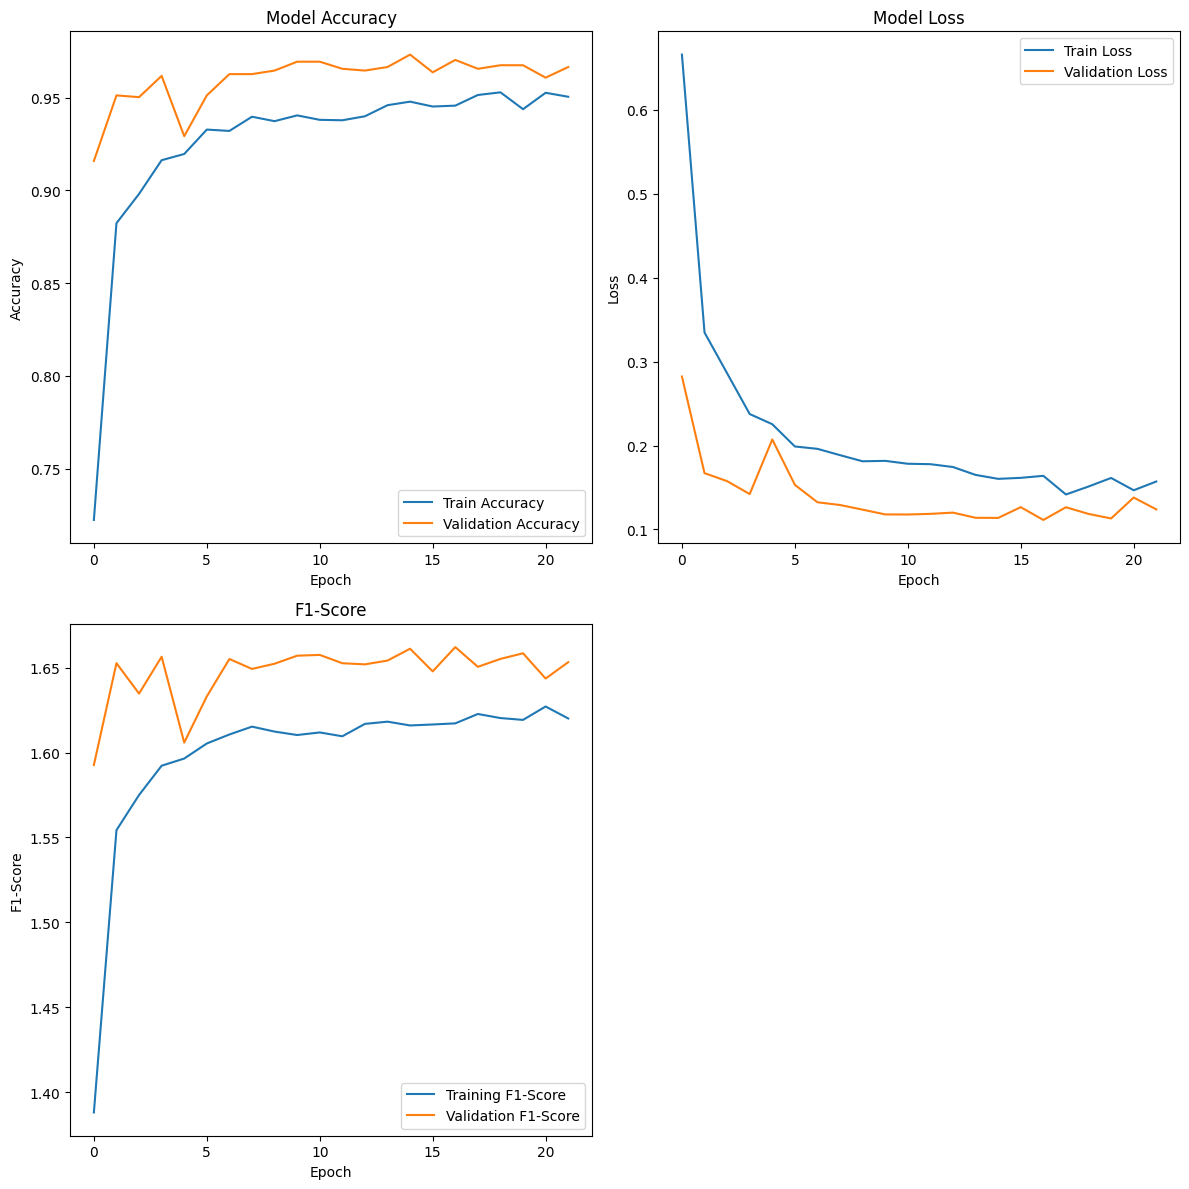

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.9692 - f1_score: 1.6640 - loss: 0.0831
Test Accuracy: 97.04%
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step
Classification Report:
               precision    recall  f1-score   support

       COVID       0.99      0.99      0.99       351
      NORMAL       0.96      0.97      0.96       330
   PNEUMONIA       0.97      0.95      0.96       365

    accuracy                           0.97      1046
   macro avg       0.97      0.97      0.97      1046
weighted avg       0.97      0.97      0.97      1046

Confusion Matrix:
 [[347   1   3]
 [  2 320   8]
 [  3  14 348]]


In [78]:
# Plot training history
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Training F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()


plt.tight_layout()
plt.show()

# Load the best model
best_model = tf.keras.models.load_model('best_paper6_model.keras', custom_objects={'F1Score': F1Score})

# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)[:2]
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = np.argmax(best_model.predict(test_images), axis=1)
y_true = np.argmax(test_labels, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))